# ECBD_PD_proyecto

## Preprocesado de datos

### Descripción de los datos

El proyecto de datos utiliza un conjunto de datos extraído de Kaggle en esta [referencia](https://www.kaggle.com/datasets/shivam2503/diamonds). Este conjunto de datos contiene información sobre diferentes características de diamantes, como puedan ser sus quilates (_carats_), su color (_color_) o su precio en _US dollars_ (_price_).

Con este conjunto de datos se busca realizar un modelo de aprendizaje automático que sea capaz de estimar el precio de un diamante acorde a sus características.

Las características en cuestión son las siguientes:

| Campo | Descripción |
|--------|--------|
| `price` | Precio en _US dollars_ ($326 - $18.823) |
|`carat` ([quilate](https://es.wikipedia.org/wiki/Quilate))| Peso del diamante (0,2 - 5,01)|
|`cut`|Calidad del corte del diamante. En orden ascendente: _Fair_, _Good_, _Very Good_, _Premium_, _Ideal_|
|`color`|Color del diamante, de J (peor) a D (mejor)|
|`clarity`| Medida de claridad del diamante. En orden ascendente: _I1_, _SI2_, _SI1_, _VS2_, _VS1_, _VVS2_, _VVS1_, _IF_|
|`x`| Largo en _mm_ (0 - 10,74)|
|`y`| Ancho en _mm_ (0 - 58,9)|
|`z`| Profundidad en _mm_ (0 - 31,8)|
|`depth`| Porcentaje de profundida del diamante respecto a su tamaño ($depth =  2 \cdot \frac{z}{x + y}$) (43 - 79)|
|`table`| Anchura del extremo del diamante respecto al punto más distante (43 - 95)|

En este caso, la característica objetivo que se busca estimar es el precio del diamante (`price`), por lo que debemos construir los modelos de aprendizaje con esta característica en mente.

In [107]:
import pandas as pd

df = pd.read_csv("../data/diamonds.csv").drop(columns = "Unnamed: 0")
display(df)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### Análisis previo de los datos

#### Analítica de datos faltantes

Comenzamos por analizar los campos del dataset en busca de registros con valores faltantes o nulo. 

In [108]:
pd.DataFrame(
    data = df.isna().sum(),
    columns = ["Valores faltantes"]
)

,Valores faltantes
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


Aparentemente no existen valores faltantes o nulos en nuestro conjunto de datos.

#### Analítica de atributos redundantes

Para analizar una posible redundancia entre atributos, calcularemos la correlación entre ellos utilizando diferentes métodos. Estos métodos son:

* Correlación de Pearson
* Correlación de Spearman

Comenzaremos por graficar las posibles combinaciones de variables:

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

[]

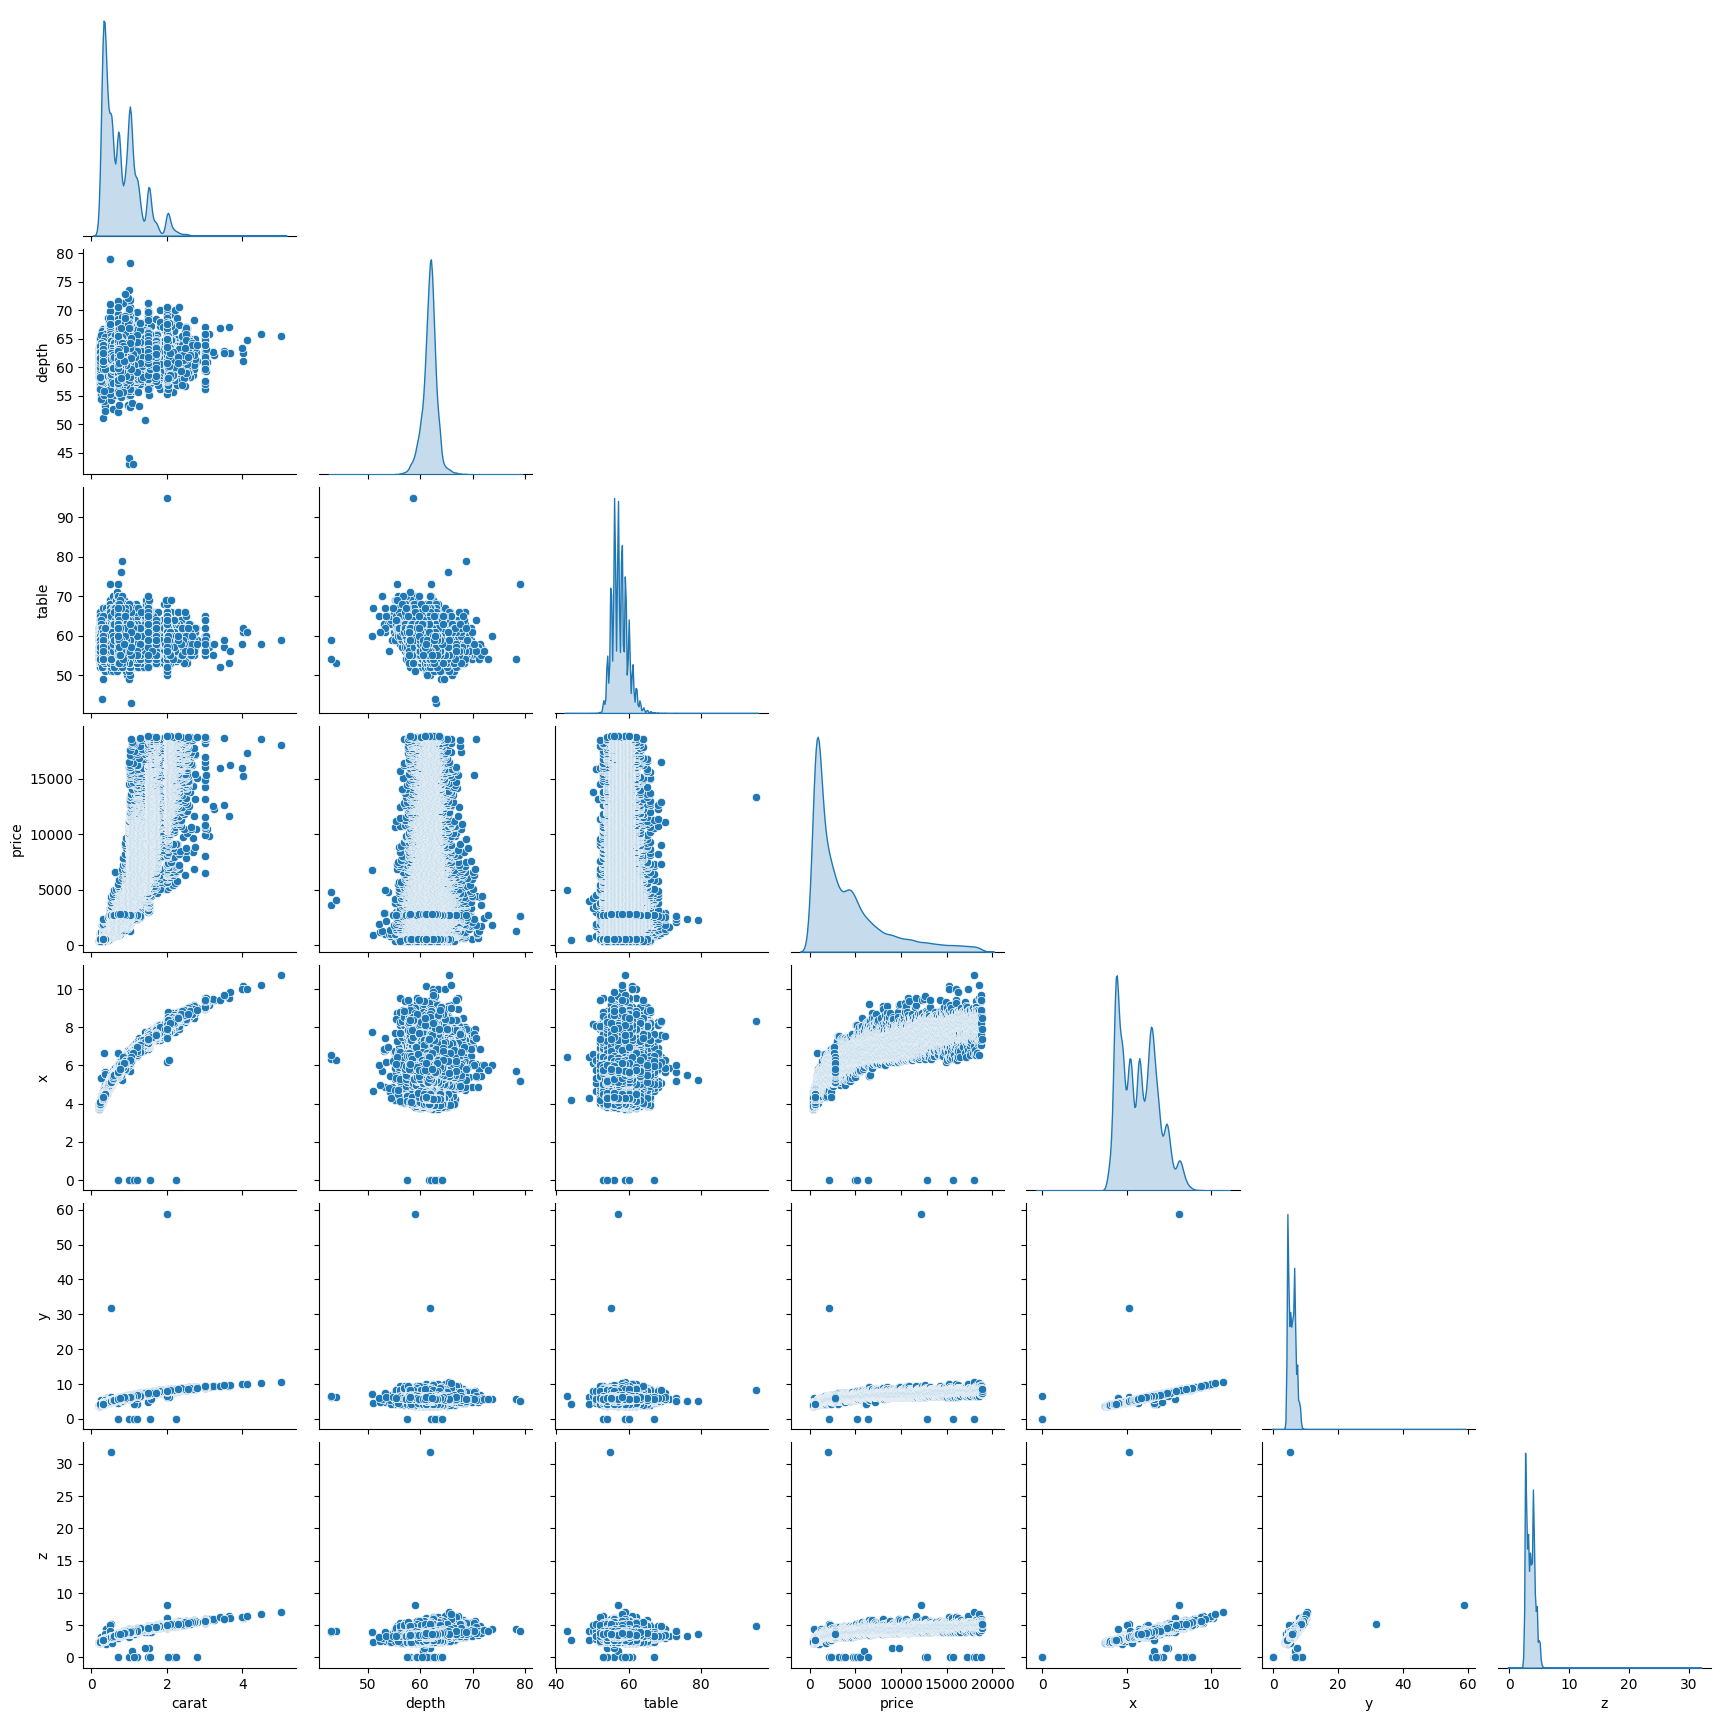

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

sns.pairplot(
    data = df[numeric_columns],
    corner = True,
    diag_kind = "kde"
)
plt.plot()

Podemos observar cómo existen a simple vista variables altamente relacionadas, como puedan ser los pares [`z`, `carat`], [`y`, `x`] y [`z`, `price`]. También podemos observar variables con poca relación aparente lineal entre sí, como puedan ser los pares [`z`, `depth`] o [`x`, `table`].

Ejecutando sobre estas variables los coeficientes de _Pearson_ y _Spearman_, obtenemos los siguientes valores:

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: title={'center': 'Correlación de Spearman'}>

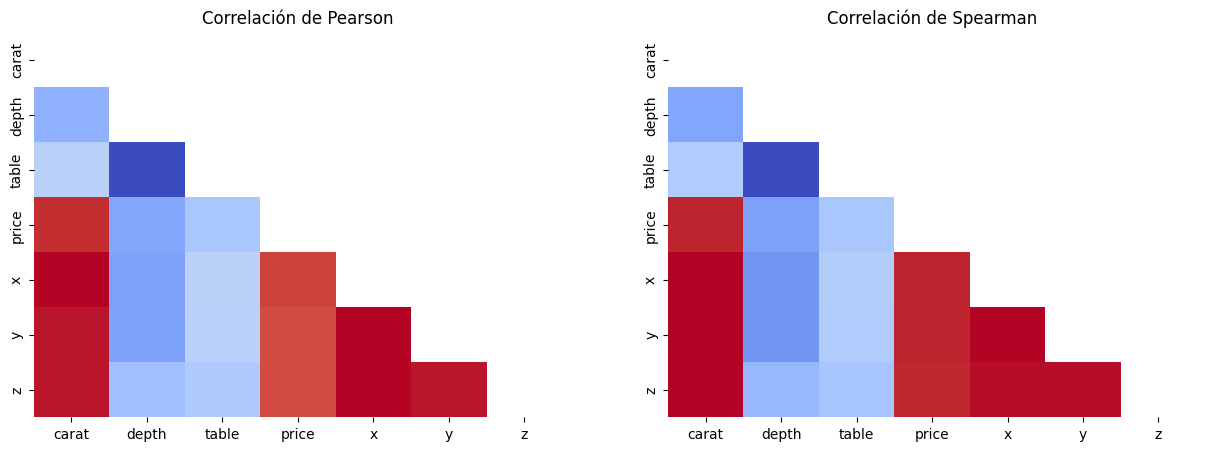

In [110]:
import numpy as np

p_man = df.corr(method = "pearson", numeric_only = True)
mask = np.triu(np.ones_like(p_man, dtype=bool))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Correlación de Pearson")
ax2.set_title("Correlación de Spearman")

sns.heatmap(
    data = df.corr(method = "pearson", numeric_only=True),
    annot = True,
    cmap = "coolwarm",
    mask = mask,
    ax = ax1,
    cbar = False
)

sns.heatmap(
    data = df.corr(method = "spearman", numeric_only=True),
    annot = True,
    cmap = "coolwarm",
    mask = mask,
    ax = ax2,
    cbar = False
)

Podemos observar que, si bien existe una alta correlación entre `carat` y los atributos de medida del diamante (`x`, `y`, y `z`), o entre `price` y las mismas unidades de medida, el resto de variables parecen ser completamente independientes, con la excepción del par [`table`, `depth`] que parecen demostrar correlaciones negativas moderadas en ambos casos.

Para poder analizar las variables categóricas, debemos aplicar correlación entre variables por hipótesis de _chi-square_.

Comenzamos con la hipótesis de que las variables a analizar son independientes entre sí, para posteriormente calcular el _p-value_ de la hipótesis (valor de confianza) aplicando _chi-square_:

* Si el _p-value_ es menor a 0.05 la hipótesis se negará: Las variables son dependientes.
* Si el _p-value_ es suficientemente alto (mayor a 0.05) la hipótesis no puede ser negada: Las variables son independientes.

In [111]:
from scipy.stats import chi2_contingency
from itertools import combinations

P_VALUE_THRESHOLD = 0.05

p_values_df = pd.DataFrame(columns = ["col1", "col2", "p_value", "variable_dependency"])

categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns = list(combinations(categorical_columns, 2))

for col1, col2 in categorical_columns:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df[col1], df[col2]))
    if p < P_VALUE_THRESHOLD:
        p_values_df = pd.concat([
            p_values_df,
            pd.DataFrame(
                data = [[col1, col2, p, "dependientes"]],
                columns = ["col1", "col2", "p_value", "variable_dependency"]
            )
        ])

display(p_values_df)

C:\Users\cabre\AppData\Local\Temp\ipykernel_14100\1757848462.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  p_values_df = pd.concat([


,col1,col2,p_value,variable_dependency
0,cut,color,1.394512e-51,dependientes
0,cut,clarity,0.000000e+00,dependientes
0,color,clarity,0.000000e+00,dependientes


Podemos determinar que las 3 variables categóricas son dependientes entre sí en pares.

Este estudio de correlaciones entre variables podrá ser aplicado posteriormente para reducir el número de variables del conjunto de datos mediante algoritmos de reducción de dimensionalidad.

#### Analítica de duplicidad de registros

Para comprobar la posible duplicidad de registros, y sabiendo que todos los atributos están correctamente formateados (lo que nos evita tener que utilizar técnicas de distancia entre textos), podemos utilizar directamente los métodos integrados de _Pandas_ para detectar duplicados.

In [112]:
df[df.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


Podemos observar un total de 146 registros duplicados de nuestro conjunto de datos, un 0.027% de los registros originales.

#### Analítica de valores anómalos (_outliers_)

Para analizar la existencia de valores outliers en nuestro conjunto de datos, realizaremos un análisis de cuartiles para cada variable numérica. De esta forma buscamos localizar aquellos valores que no se encuentren dentro de los límites esperados.

El criterio para determinar un posible valor outlier está en marcar como "posibles outliers" todos aquellos valores que se alejen en 1,5 veces del rango intercuartílico.

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

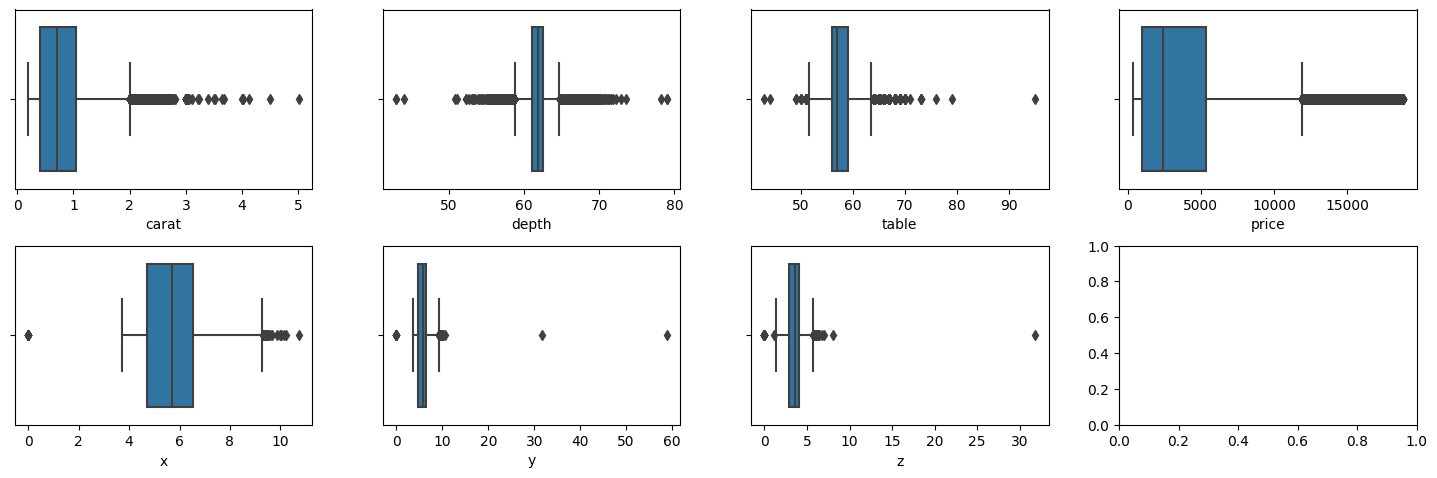

In [113]:
fig, ax = plt.subplots(
    figsize = (15, 5),
    ncols = 4,
    nrows = len(numeric_columns) // 4 + 1,
)
fig.tight_layout(pad = 2.0)


for i, col in enumerate(numeric_columns):
    sub_ax = ax[i // 4][i % 4]

    sns.boxplot(
        data = df,
        x = col,
        ax = sub_ax
    )

En todas las variables numéricas podemos observar datos alejados del rango intercuartílico, que podrían ser marcados como _outliers_. Sin embargo, no todos los valores extremos de estas gráficas anteriores deberían ser contados como valores anómalos, pues muchos de ellos serán simplemente muestras poco comunes pero válidas.

Cada atributo debe ser analizado de forma individual.

##### `carat`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='carat'>

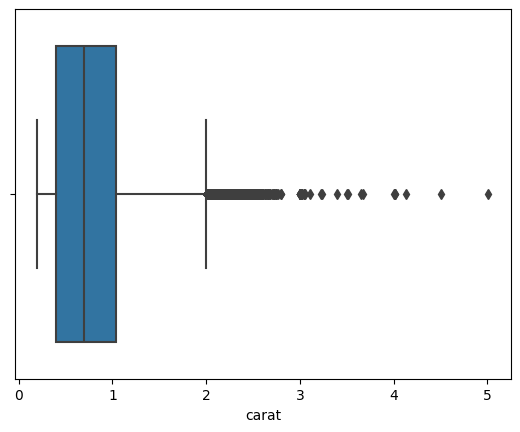

In [114]:
sns.boxplot(data = df, x = 'carat')

Podemos observar que la mayor parte de los diamantes registrados son de 1 o 2 quilate, siendo el grueso de "posibles _outliers_" diamantes de _2.x_ quilates. Son valores perfectamente válidos, pues aunque poco frecuentes es plausible la existencia de diamantes de 3-5 quilates.

##### `depth`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='depth'>

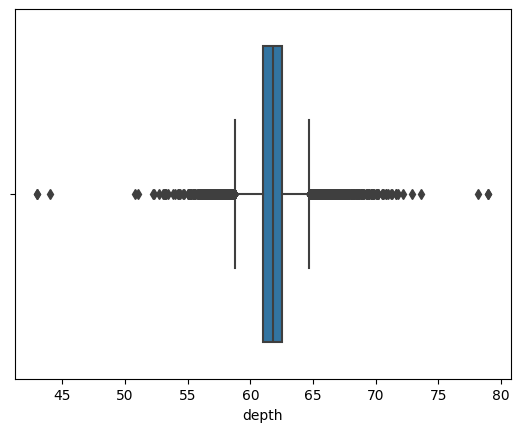

In [115]:
sns.boxplot(data = df, x = 'depth')

En el campo `depth` no se aprecian valores anómalos, pues no deja de ser una variable derivada de otras anteriores.

##### `table`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='table'>

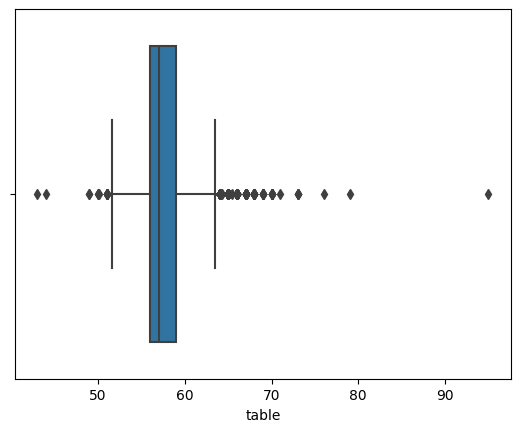

In [116]:
sns.boxplot(data = df, x = 'table')

El campo `table` no despierta tampoco sospechas de valores anómalos, salvo por la muestra extrema de `table = 95`. Se podría eliminar ese punto para evitar posibles problemas.

##### `price`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='price'>

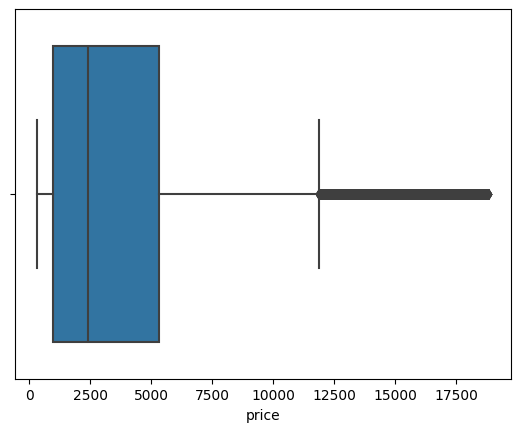

In [117]:
sns.boxplot(data = df, x = 'price')

El atributo `price` y su distribución de puntos extremos negros ubicados al final del gráfico de cajas nos indica una distribución de datos asimétrica, donde hay muchas entradas con precios bajos y pocas con precios elevados.

##### `x`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x'>

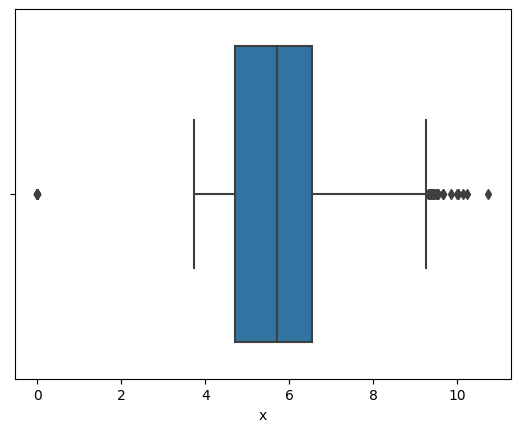

In [118]:
sns.boxplot(data = df, x = 'x')

En el caso de `x` podemos observar valores outliers a partir de la longitud ~9, lo que puede indicar pocos diamantes tan grandes. Sin embargo, también se observan al menos una entrada de longitud `x = 0`, lo cual es virtualmente imposible.

Se recomienda para este atributo eliminar esas entradas.

##### `y`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='y'>

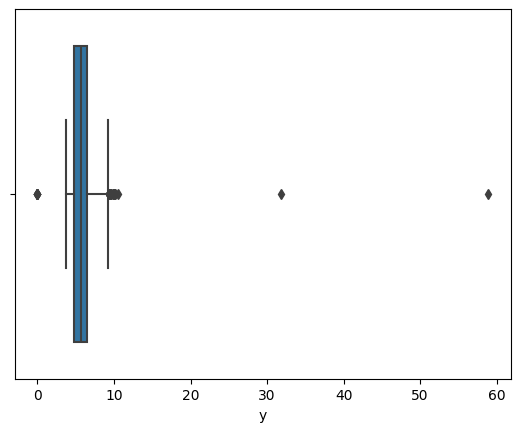

In [119]:
sns.boxplot(data = df, x = 'y')

De forma similar al atributo `x`, en el caso del atributo `y` podemos observar ciertos valores elevados marcados como outliers y unos pocos valores de altura nula.

Para este atributo se recomienda eliminar aquellas entradas con `y = 0`.

##### `z`

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='z'>

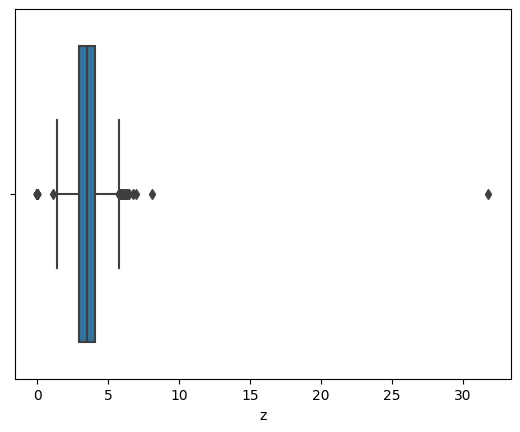

In [120]:
sns.boxplot(data = df, x = 'z')

De forma similar al atributo `x`, en el caso del atributo `z` podemos observar ciertos valores elevados marcados como outliers y unos pocos valores de profundidad nula.

Para este atributo se recomienda eliminar aquellas entradas con `z = 0`.

### Corrección de atributos redundantes

Buscamos reducir el número de atributos de nuestro conjunto de datos. Para ello, utilizaremos el método integrado (_embedded_).

Text(0.5, 1.0, 'Importancia de los atributos')

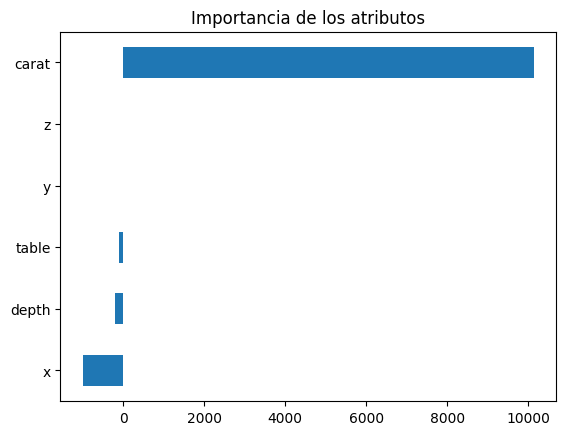

In [121]:
from sklearn.linear_model import LassoCV

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns.drop("price")

reg = LassoCV()
reg.fit(df[numeric_columns], df["price"])
coef = pd.Series(reg.coef_, index = numeric_columns)

imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Importancia de los atributos")

Podemos observar que, después del proceso iterativo que sigue el algoritmo Lasso CV para asignar importancia a las variables, los atributos `z` e `y` son marcados como "irrelevantes" para nuestro proyecto (coeficiente = 0), por lo que pueden ser eliminados sin afectar drásticamente el rendimiento de posibles modelos.

In [122]:
df = df.drop(columns = ["y", "z"])

### Corrección de duplicidad de registros

Para la eliminación de registros duplicados se ha decidido utilizar los métodos integrados de `pandas` para eliminar registros duplicados de un _Dataframe_.

In [123]:
df = df.drop_duplicates()

display(df.duplicated().sum())

0

### Corrección de _outliers_

Para la corrección de _outliers_, se decidió anteriormente eliminar aquellas entradas con los campos de distancia (`x`, `y` y `z`). Sabiendo que los campos `y` y `z` han sido eliminados del conjunto de datos por ser irrelevantes, solo queda eliminar aquellas entradas cuyo $x = 0$.

In [124]:
df = df.drop(df[df["x"] == 0].index)

display(df[df["x"] == 0].size)

0

In [125]:
df.head()

,carat,cut,color,clarity,depth,table,price,x
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89
2,0.23,Good,E,VS1,56.9,65.0,327,4.05
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20
4,0.31,Good,J,SI2,63.3,58.0,335,4.34


### Normalización de datos

Para el proceso de normalización de variables numéricas, primero debemos observar la distribución de las variables numéricas de las que disponemos:

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

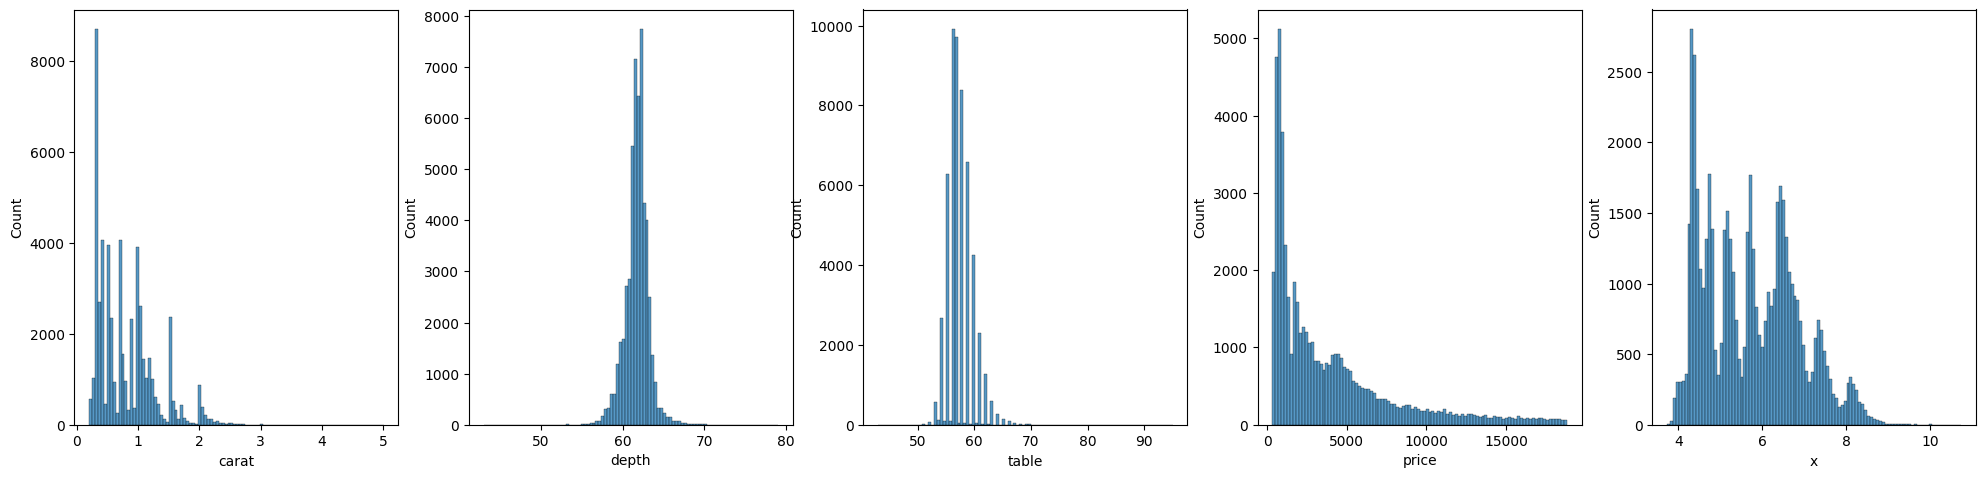

In [126]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

fig, ax = plt.subplots(figsize = (20, 5), ncols = 5)

fig.tight_layout(pad = 2.0)

for i, col in enumerate(numeric_columns):
    sns.histplot(
        data = df,
        x = col,
        bins = 100,
        ax = ax[i]
    )

Como podemos observar, las variables `depth` y table muestran una distribución cercana a la normal, en comparación con las variables `carat`, `price` y `x`. Para este conjunto de 5 variables vamos a aplicar las siguientes normalizaciones:

* Normalización por _z-score_
    * `depth`
    * `table`
* Normalización por _min\_max_
    * `carat`
    * `price`
    * `x`

In [127]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

old_df = df.copy(deep = True)

# Normalizacion por z_score
df['depth'] = std_scaler.fit_transform(df[['depth']])
df['table'] = std_scaler.fit_transform(df[['table']])

# Normalizacion por minmax
df['carat'] = minmax_scaler.fit_transform(df[['carat']])
df['x']     = minmax_scaler.fit_transform(df[['x']])
df['price'] = minmax_scaler.fit_transform(df[['price']])

Una vez calculados, podremos mostrar los datos originales frente a sus versiones normalizadas:

c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cabre\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

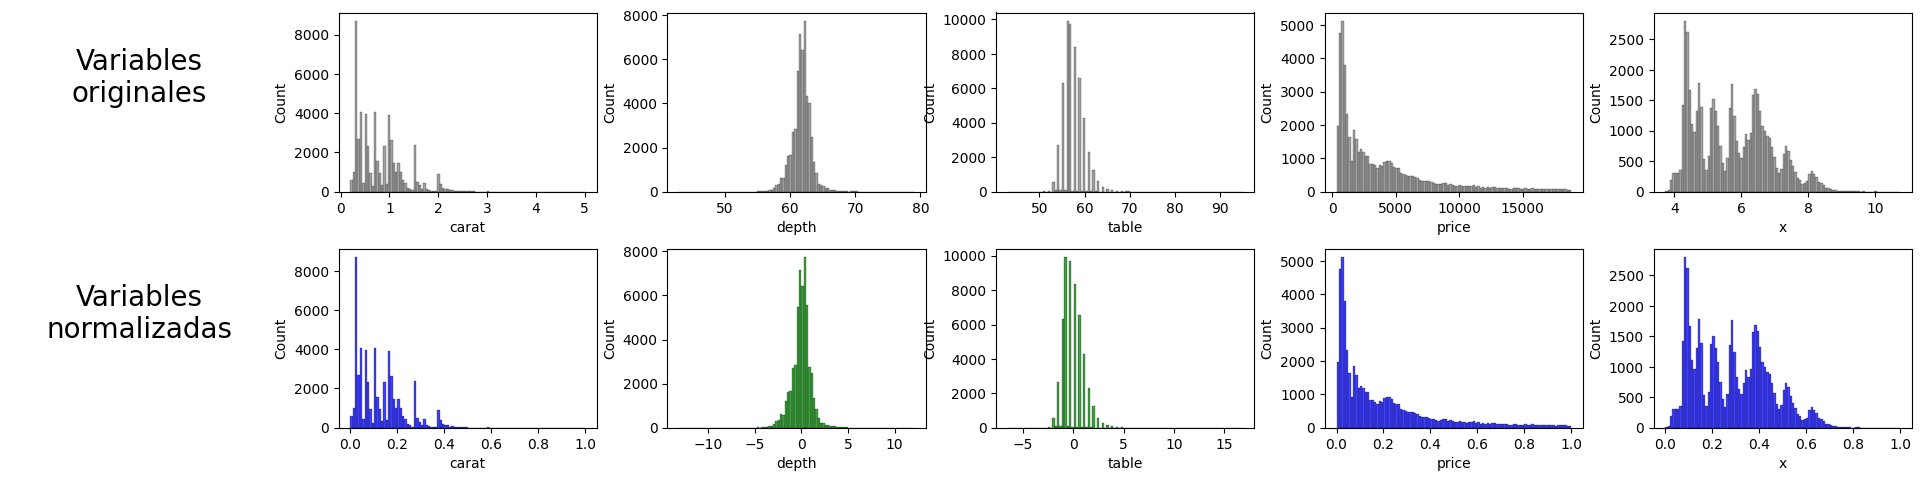

In [143]:
fig, ax = plt.subplots(figsize = (20, 5), ncols = 6, nrows = 2)
fig.tight_layout(pad = 2.0)

# Variables numericas originales
ax[0][0].axis('off')
ax[0][0].text(0.5, 0.5, 'Variables\noriginales', fontsize = 20, ha = 'center')
for i, col in enumerate(numeric_columns):
    sns.histplot(
        data = old_df,
        x = col,
        bins = 100,
        ax = ax[0][i + 1],
        color = "gray"
    )

# Variables numericas normalizadas
ax[1][0].axis('off')
ax[1][0].text(0.5, 0.5, 'Variables\nnormalizadas', fontsize = 20, ha = 'center')
for i, col in enumerate(numeric_columns):
    sns.histplot(
        data = df,
        x = col,
        bins = 100,
        ax = ax[1][i + 1],
        color = "green" if col in ['depth', 'table'] else "blue"
    )


En azul se marcan las variables normalizadas con el algoritmo _min\_max_, mientras que en verde las variables normalizadas con _z-score_.

### Codificación de variables

Para que los futuros modelos de regresión funcionen correctamente, codificaremos las variables categóricas para convertirlas en variables _dummies_.

In [60]:
df = pd.get_dummies(df, drop_first = True)

,carat,depth,table,price,x,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.72,63.1,55.0,2757,5.69,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.70,62.8,60.0,2757,5.66,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.86,61.0,58.0,2757,6.15,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False


## Extracción de conocimiento

### Modelo de regresión

#### Descripción del modelo

#### Creación de subconjuntos de entrenamiento y prueba

Para nuestro modelo de predicción, utilizaremos un sistema de validación cruzada con el objetivo de asegurarnos de que el modelo generado no presente sobreajuste, además de comprobar su rendimiento en diferentes instancias del problema.

La validación cruzada a ejecutar constará de 5 pliegues (_folds_) y un porcentaje de entradas de pruebas del 20%.

In [ ]:

# WARNING: Este codigo no ha sido probado, lo solto chatgpt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
import numpy as np

# Supongamos que tienes tus datos en X e y

# Crear el modelo de regresión lineal
modelo_regresion = LinearRegression()

# Definir la función de puntuación utilizando el deviance
def calcular_rmd(y_true, y_pred):
    residuos = y_true - y_pred
    deviance = np.mean(np.square(residuos))
    return deviance

# Convertir la función de puntuación en un objeto scorer
scorer = make_scorer(calcular_rmd, greater_is_better=False)

# Realizar la validación cruzada y obtener los resultados
resultados_cross_val = cross_val_score(modelo_regresion, X, y, cv=5, scoring=scorer)

# Imprimir los resultados para cada iteración
for i, rmd_iteracion in enumerate(resultados_cross_val, 1):
    print(f"Iteración {i}: RMD = {-rmd_iteracion}")  # Multiplicamos por -1 ya que cross_val_score maximiza la puntuación

# También puedes calcular la media y la desviación estándar de los RMD
media_rmd = -resultados_cross_val.mean()
std_rmd = resultados_cross_val.std()

print(f"\nMedia de RMD: {media_rmd}")
print(f"Desviación estándar de RMD: {std_rmd}")

#### Creación y entrenamiento del modelo

#### Testeo del modelo

#### Análisis de resultados

### Modelo de agrupamiento

#### Descripción del modelo

#### Creación y alimentación del modelo

#### Testeo del modelo

#### Análisis de resultados